<h1>Part 1: Exchaustive Search<h/1>

<h3>Dependencies<h/3>

In [22]:
import numpy as np
import skimage as sk
from skimage import img_as_ubyte
import skimage.io as skio
import matplotlib.pyplot as plt

<h3>Functions<h/3>

In [23]:

def normalized_cross_correlation(img1, img2):
    img1_normalized = (img1 - np.mean(img1)) / (np.std(img1) + 1e-8)
    img2_normalized = (img2 - np.mean(img2)) / (np.std(img2) + 1e-8)
    return np.sum(img1_normalized * img2_normalized)

def align(image, reference, search_window=90, crop_size=15):
    best_score = float('-inf')
    best_shift = (0, 0)
    
    height, width = image.shape
    
    for y_shift in range(-search_window, search_window + 1):
        for x_shift in range(-search_window, search_window + 1):
            shifted = np.roll(image, (y_shift, x_shift), axis=(0, 1))
            
            # Exclude borders (crop to internal pixels only)
            y_start = max(crop_size, -y_shift)
            y_end = min(height - crop_size, height - y_shift)
            x_start = max(crop_size, -x_shift)
            x_end = min(width - crop_size, width - x_shift)
            
            score = normalized_cross_correlation(
                shifted[y_start:y_end, x_start:x_end],
                reference[y_start:y_end, x_start:x_end]
            )
            
            if score > best_score:
                best_score = score
                best_shift = (y_shift, x_shift)
    
    return np.roll(image, best_shift, axis=(0, 1)), best_shift

<h3>Main<h/3>

Processing data/cathedral.jpg
Green channel shift: (5, 2)
Red channel shift: (12, 3)


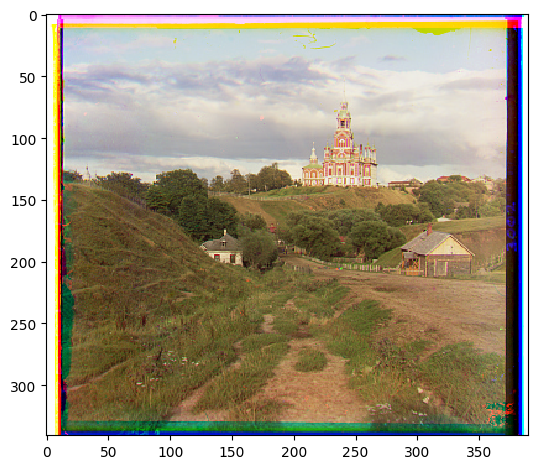

Processing data/monastery.jpg
Green channel shift: (-3, 2)
Red channel shift: (3, 2)


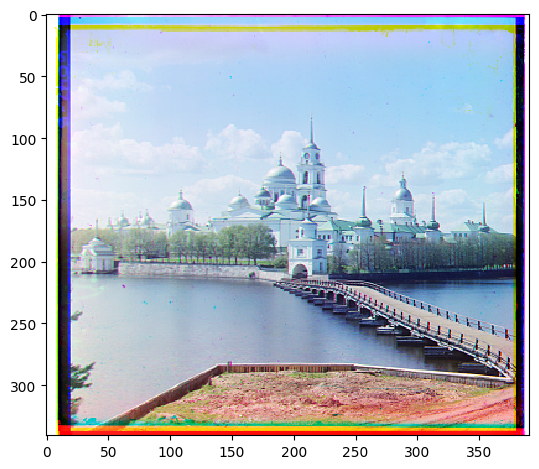

Processing data/tobolsk.jpg
Green channel shift: (3, 2)
Red channel shift: (6, 3)


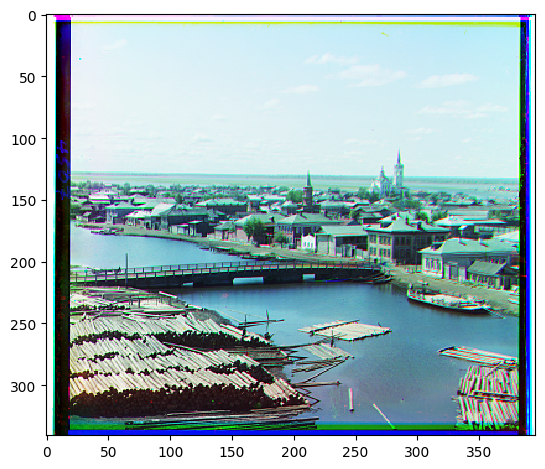

In [24]:

# List of image filenames
image_files = ['data/cathedral.jpg', 'data/monastery.jpg', 'data/tobolsk.jpg']

# Loop through each image
for image_file in image_files:

    im = skio.imread(image_file)

    # Convert to float format (you can do this later to save memory if needed)
    im = sk.img_as_float(im)

    # Compute the height of each part (1/3 of total height)
    height = int(np.floor(im.shape[0] / 3.0))

    # Separate the color channels (assuming RGB stored as 3 horizontal sections)
    b = im[:height]      # Blue channel
    g = im[height: 2*height]  # Green channel
    r = im[2*height: 3*height]  # Red channel

    # Align the images
    ag, g_shift = align(g, b)   # Align green channel to blue
    ar, r_shift = align(r, b)   # Align red channel to blue

    # Stack the aligned images to create the final color image
    im_out = np.dstack([ar, ag, b])

    # Convert to uint8 format
    im_out = img_as_ubyte(im_out)

    # Print the displacement vectors
    print(f"Processing {image_file}")
    print(f"Green channel shift: {g_shift}")
    print(f"Red channel shift: {r_shift}")

    # Create the output filename based on the input image name
    output_filename = f"aligned_{image_file.split('/')[-1]}"

    # Save the aligned image
    skio.imsave(output_filename, im_out)

    # Optionally display the image (comment out if not needed)
    skio.imshow(im_out)
    skio.show()

<h1>Part 2: Pyramid Speed Up<h/1>

<h3>Functions<h/3>

In [25]:

def compute_normalized_cross_correlation(im1, im2):
    im1_norm = (im1 - np.mean(im1)) / np.linalg.norm(im1)
    im2_norm = (im2 - np.mean(im2)) / np.linalg.norm(im2)
    return np.sum(im1_norm * im2_norm)

def compute_shift_difference(im1, im2):
    im1_diff = im1 - np.roll(im1, 2, 1)
    im2_diff = im2 - np.roll(im2, 2, 1)
    return compute_normalized_cross_correlation(im1_diff, im2_diff)

def pyramid_align(image, reference, min_size=32, search_window=15):
    image_pyramid = build_pyramid(image, min_size)
    reference_pyramid = build_pyramid(reference, min_size)
    
    displacement = np.array([0, 0])
    
    for i in range(len(image_pyramid) - 1, -1, -1):
        current_window = max(1, search_window // (2 ** (len(image_pyramid) - 1 - i)))
        level_displacement = align(image_pyramid[i], reference_pyramid[i], 
                                   search_window=current_window, 
                                   start_displacement=displacement * 2)
        displacement = displacement * 2 + level_displacement
    
    aligned_image = apply_displacement(image, displacement)
    return aligned_image, displacement

def build_pyramid(image, min_size):
    pyramid = [image]
    while min(image.shape[:2]) > min_size:
        image = downsample(image)
        pyramid.append(image)
    return pyramid[::-1]

def downsample(image):
    if image.shape[0] % 2 != 0:
        image = image[:-1, :]
    if image.shape[1] % 2 != 0:
        image = image[:, :-1]
    return (image[::2, ::2] + image[1::2, ::2] + image[::2, 1::2] + image[1::2, 1::2]) / 4

def align(image, reference, search_window, start_displacement):
    best_score = -np.inf
    best_displacement = start_displacement
    
    cut_amount = max(int(len(reference) * 0.1), 1)
    cut_reference = reference[cut_amount:-cut_amount, cut_amount:-cut_amount]
    
    for dy in range(-search_window, search_window + 1):
        for dx in range(-search_window, search_window + 1):
            displacement = start_displacement + np.array([dy, dx])
            shifted = apply_displacement(image, displacement)
            cut_shifted = shifted[cut_amount:-cut_amount, cut_amount:-cut_amount]
            score = compute_shift_difference(cut_shifted, cut_reference)
            
            if score > best_score:
                best_score = score
                best_displacement = displacement
    
    return best_displacement - start_displacement

def apply_displacement(image, displacement):
    return np.roll(np.roll(image, int(displacement[0]), axis=0), int(displacement[1]), axis=1)

def display_alignment(original, aligned, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(aligned)
    ax2.set_title('Aligned')
    ax2.axis('off')
    plt.suptitle(title)
    plt.show()

Processing cathedral.jpg
set image 0 to position [0, 0]
set image 1 to position [28, -18]
set image 2 to position [84, -38]
set image 3 to position [172, -76]
set image 3 to position [170, -76]
set image 0 to position [0, 0]
set image 1 to position [26, -18]
set image 2 to position [64, -38]
set image 3 to position [156, -76]
set image 3 to position [153, -78]


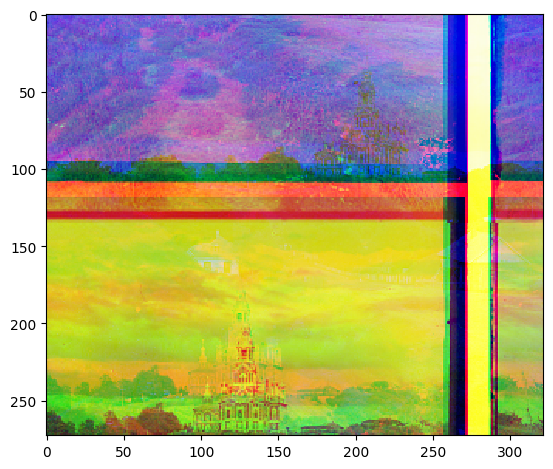

Processing church.tif
set image 0 to position [0, 0]
set image 1 to position [6, 18]
set image 2 to position [10, 36]
set image 3 to position [20, 70]
set image 3 to position [21, 72]
set image 0 to position [0, 0]
set image 1 to position [16, 16]
set image 2 to position [28, 4]
set image 3 to position [58, 2]
set image 3 to position [58, 0]


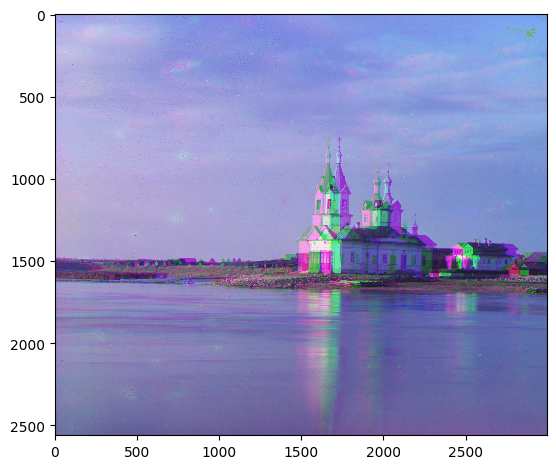

Processing emir.tif
set image 0 to position [0, 0]
set image 1 to position [12, 0]
set image 2 to position [24, 6]
set image 3 to position [48, 16]
set image 3 to position [49, 17]
set image 0 to position [0, 0]
set image 1 to position [28, 8]
set image 2 to position [56, 18]
set image 3 to position [108, 36]
set image 3 to position [107, 37]


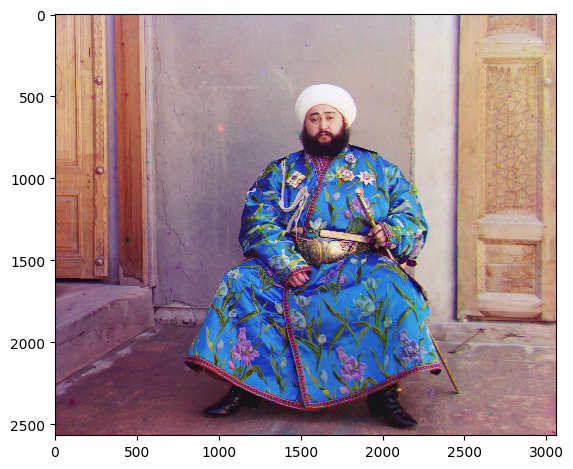

Processing harvesters.tif
set image 0 to position [0, 0]
set image 1 to position [14, -2]
set image 2 to position [30, 0]
set image 3 to position [58, 4]
set image 3 to position [58, 6]
set image 0 to position [0, 0]
set image 1 to position [28, 12]
set image 2 to position [62, 0]
set image 3 to position [124, 2]
set image 3 to position [123, 3]


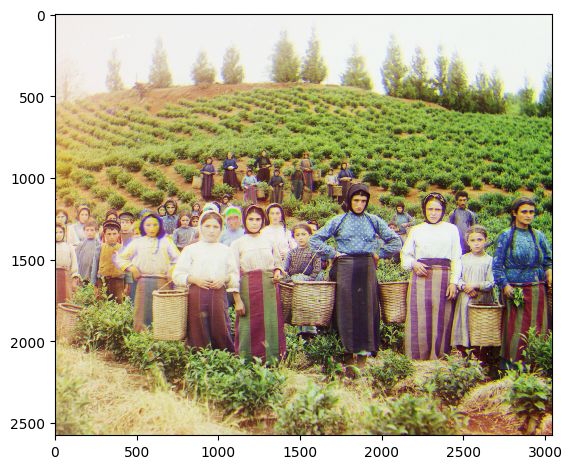

Processing icon.tif
set image 0 to position [0, 0]
set image 1 to position [10, 10]
set image 2 to position [20, 14]
set image 3 to position [40, 10]
set image 3 to position [39, 12]
set image 0 to position [0, 0]
set image 1 to position [22, 10]
set image 2 to position [44, 16]


In [26]:
import numpy as np
import skimage as sk
import skimage.io as skio
import os

def compute_normalized_cross_correlation(im1, im2):
    im1_length = (im1 - np.mean(im1)) / np.linalg.norm(im1)
    im2_length = (im2 - np.mean(im2)) / np.linalg.norm(im2)
    im1_length = im1_length.flatten()
    im2_length = im2_length.flatten()
    return np.dot(im1_length, im2_length)

def compute_shift_difference(im1, im2):
    im1_difference_matrix = im1 - np.roll(im1, 2, 1)
    im2_difference_matrix = im2 - np.roll(im2, 2, 1)
    return compute_normalized_cross_correlation(im1_difference_matrix, im2_difference_matrix)

def get_best_displacement(im1, im2, on_last_level):
    max_displacement = 15
    skip_factor = 1
    
    if on_last_level:
        max_displacement = 3
    
    best_alignment_displacement = 0, 0
    best_alignment_distance = np.inf

    cut_amount = max(int(len(im1) * 0.25), 1)
    cut_im2 = im2[cut_amount:-cut_amount, cut_amount:-cut_amount]

    for y_displacement in range(-max_displacement, max_displacement, skip_factor):
        y_rolled_im1 = np.roll(im1, y_displacement, 0)
        for x_displacement in range(-max_displacement, max_displacement, skip_factor):
            xy_rolled_im1 = np.roll(y_rolled_im1, x_displacement, 1)
            cut_im1 = xy_rolled_im1[cut_amount:-cut_amount, cut_amount:-cut_amount]
            new_aligment_distance = compute_shift_difference(cut_im1, cut_im2)
            if new_aligment_distance < best_alignment_distance:
                best_alignment_displacement = y_displacement, x_displacement
                best_alignment_distance = new_aligment_distance

    return best_alignment_displacement

def align(im1, im2):
    amount_of_images = 3
    low_resolution_images1 = []
    for i in range(amount_of_images, 0, -1):
        low_resolution_images1.append(sk.transform.rescale(im1, 0.5**i))
    low_resolution_images1.append(im1)

    low_resolution_images2 = []
    for i in range(amount_of_images, 0, -1):
        low_resolution_images2.append(sk.transform.rescale(im2, 0.5**i))
    low_resolution_images2.append(im2)

    total_displacement = [0, 0]
    displacement = [0, 0]

    for i in range(0, len(low_resolution_images1)):
        total_displacement = [2* (total_displacement[0] + displacement[0]), 2 * (total_displacement[1] + displacement[1])]
        low_resolution_images1[i] = np.roll(low_resolution_images1[i], total_displacement[0], 0)
        low_resolution_images1[i] = np.roll(low_resolution_images1[i], total_displacement[1], 1)
        print("set image " + str(i) + " to position " + str(total_displacement))

        on_last_level = i == len(low_resolution_images1) - 1
        displacement = get_best_displacement(low_resolution_images1[i], low_resolution_images2[i], on_last_level)

    total_displacement = [total_displacement[0] + displacement[0], total_displacement[1] + displacement[1]]
    low_resolution_images1[-1] = np.roll(low_resolution_images1[-1], displacement[0], 0)
    low_resolution_images1[-1] = np.roll(low_resolution_images1[-1], displacement[1], 1)
    print("set image " + str(i) + " to position " + str(total_displacement))

    return low_resolution_images1[-1]

def process_image(imname):
    print(f"Processing {imname}")
    im = skio.imread(f"data/{imname}")
    im = sk.img_as_float(im)
    
    height = np.floor(im.shape[0] / 3.0).astype(int)
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    ag = align(g, b)
    ar = align(r, b)

    cut_amount = max(int(len(b) * 0.1), 1)

    b = (b[cut_amount:-cut_amount, cut_amount:-cut_amount] * 255).astype(np.uint8)
    ag = (ag[cut_amount:-cut_amount, cut_amount:-cut_amount] * 255).astype(np.uint8)
    ar = (ar[cut_amount:-cut_amount, cut_amount:-cut_amount] * 255).astype(np.uint8)

    im_out = np.dstack([ar, ag, b])

    # Ensure output directory exists
    os.makedirs('./out_path', exist_ok=True)

    fname = f'./out_path/aligned_{os.path.splitext(imname)[0]}.jpg'
    skio.imsave(fname, im_out)

    # Display the image (optional, comment out if not needed)
    skio.imshow(im_out)
    skio.show()

# List of image files
image_files = [
    'cathedral.jpg', 'church.tif', 'emir.tif', 'harvesters.tif', 'icon.tif',
    'lady.tif', 'melons.tif', 'monastery.jpg', 'onion_church.tif',
    'sculpture.tif', 'self_portrait.tif', 'three_generations.tif',
    'tobolsk.jpg', 'train.tif'
]

for imname in image_files:
    process_image(imname)

print("Processing complete. All aligned images have been saved in ./out_path/")